In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import cluster
import matplotlib.pyplot as plt

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
filename = '/content/gdrive/My Drive/Datasets/train.csv'

In [4]:
# Import and subset starter features
data = pd.read_csv(filename)
starterFeatures = data[['rsi14','sma9_var', 'sma180_var', 'vwap_var']]
starterFeatures.values # Now np array

array([[ 3.05097608e+01, -6.22295056e-03, -2.26789532e-02,
        -1.75263798e-02],
       [ 4.64527415e+01, -1.06159541e-03, -4.72095039e-03,
        -7.71311385e-03],
       [ 3.43362238e+01, -4.44335091e-03, -1.66481693e-02,
        -1.65887992e-02],
       ...,
       [ 4.15506365e+01, -1.99079526e-03, -1.47744623e-02,
        -3.80272760e-03],
       [ 3.54330613e+01, -5.42660160e-03, -1.26001612e-02,
        -1.57668748e-02],
       [ 3.76485639e+01, -4.00720367e-03, -1.61337123e-02,
        -1.65276248e-02]])

In [5]:
# Normalize starter features
min_max_scaler = preprocessing.MinMaxScaler()
startersScaled = min_max_scaler.fit_transform(starterFeatures)
subset = pd.DataFrame(startersScaled)
print(subset.head())


          0         1         2         3
0  0.371055  0.613722  0.460930  0.549934
1  0.613812  0.843916  0.507860  0.599319
2  0.429319  0.693091  0.476690  0.554652
3  0.463555  0.846391  0.535086  0.616602
4  0.349795  0.848878  0.527060  0.629240


In [56]:
####################################### kmeans cluster
kmeans = cluster.KMeans(n_clusters=4, max_iter=50, random_state=1)
kmeans.fit(subset)
labels = kmeans.labels_
post_clusterDF = pd.DataFrame(labels, index=subset.index, columns=['Cluster ID'])

In [42]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids,columns=subset.columns)

,0,1,2,3
0,0.377695,0.534634,0.435703,0.525002
1,0.493932,0.820690,0.505432,0.611569
2,0.372181,0.776089,0.483777,0.580402


In [57]:
from sklearn.metrics import silhouette_score
a=0
for i in range(0, 10):
  a=a+silhouette_score(subset, labels, sample_size=10000)

print(a/10)

0.3054318465023813


In [59]:
update_data=pd.concat((data, pd.DataFrame(np.asarray(labels), columns=['Cluster ID'])), axis=1)
temp=update_data[['is_profit', 'Cluster ID']]

In [60]:
temp.loc[(temp['Cluster ID']==0)&(temp['is_profit']==True)].count()/temp.loc[(temp['Cluster ID']==0)].count()

is_profit     0.734311
Cluster ID    0.734311
dtype: float64

In [61]:
temp.loc[(temp['Cluster ID']==1)&(temp['is_profit']==True)].count()/temp.loc[(temp['Cluster ID']==1)].count()

is_profit     0.307405
Cluster ID    0.307405
dtype: float64

In [62]:
temp.loc[(temp['Cluster ID']==2)&(temp['is_profit']==True)].count()/temp.loc[(temp['Cluster ID']==2)].count()

is_profit     0.309672
Cluster ID    0.309672
dtype: float64

In [63]:
temp.loc[(temp['Cluster ID']==3)&(temp['is_profit']==True)].count()/temp.loc[(temp['Cluster ID']==3)].count()

is_profit     0.593885
Cluster ID    0.593885
dtype: float64

5


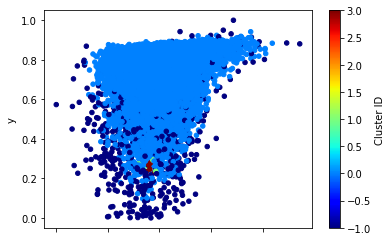

In [ ]:
########################

from sklearn.cluster import DBSCAN 
import numpy as np

#db=DBSCAN(eps=15.5, min_samples=5).fit(subset)  #Runtime issues with all data points

#Starts to really slow down after about 50000 points
small=subset[0:40000].to_numpy()
db=DBSCAN(eps=0.05, min_samples=6).fit(small)
print(len(np.unique(db.labels_)))
labels=pd.DataFrame(db.labels_, columns=['Cluster ID'])
result=pd.concat((pd.DataFrame(small[:,:2], columns=['x', 'y']), labels), axis=1)
result.plot.scatter(x='x', y='y', c='Cluster ID', colormap='jet')

#Due to a large central density region of points, with no well defined clusters of different densities, DBSCAN does not seem to be appropriate

In [ ]:
##################################### disregard this cell, skfuzzy doesn't return probabilities

#!pip install -U scikit-fuzzy
import skfuzzy as fuzz
cntr, u_orig, _, _, _, _, _=fuzz.cluster.cmeans(small, c=3, m=2, error=0.005, maxiter=1000, init=None)

test = fuzz.cluster.cmeans_predict(small, cntr, 2, error=0.005, maxiter=1000)
test

(array([[3.94912075e-02, 2.10144830e-06, 2.56856631e-01, 9.96727969e-01],
        [9.10342707e-03, 9.99997057e-01, 3.06735789e-02, 1.13068524e-03],
        [9.51405365e-01, 8.41404922e-07, 7.12469790e-01, 2.14134598e-03]]),
 array([[0.09341315, 0.86521651, 0.28154749, 0.27470673],
        [0.85040941, 0.02922016, 0.36499283, 0.6909107 ],
        [0.05617744, 0.10556333, 0.35345968, 0.03438258]]),
 array([[3.36257842e+01, 4.14257291e+01, 2.01516265e+01, 1.35825481e+00],
        [7.00358122e+01, 6.00523704e-02, 5.83140587e+01, 4.03272596e+01],
        [6.85077698e+00, 6.54676861e+01, 1.20996350e+01, 2.93039491e+01]]),
 array([6170.70302731,  150.80128036]),
 2,
 0.8687026545433669)

In [74]:
#!pip install fuzzy-c-means
# Use fuzzy-c-means instead because fcm.u gives the cluster probabilities 

from fcmeans import FCM
fcm=FCM(n_clusters=3)
#fcm.fit(data.drop(columns=['is_profit', 'sym', 'datetime']).to_numpy())
fcm.fit(subset.to_numpy())
fcm.u
#fcm.centers
#fcm.labels=fcm.predict(data.drop(columns=['is_profit', 'sym', 'datetime']).to_numpy())
fcm.labels=fcm.predict(subset.to_numpy())

In [8]:
fcm.centers

DeviceArray([[0.49317196, 0.82373524, 0.505438  , 0.6118867 ],
             [0.38489777, 0.7886974 , 0.48901868, 0.5874346 ],
             [0.3783791 , 0.59017557, 0.44710076, 0.5396503 ]],            dtype=float32)

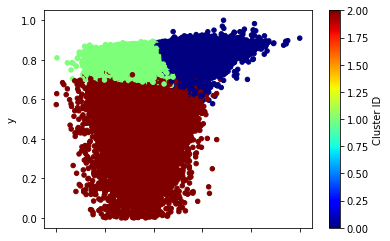

In [75]:
import numpy as np
result=pd.concat((pd.DataFrame(subset.to_numpy()[:,:2], columns=['x', 'y']), pd.DataFrame(np.asarray(fcm.labels), columns=['Cluster ID'])), axis=1)
result.plot.scatter(x='x', y='y', c='Cluster ID', colormap='jet')

In [76]:
fcm.labels

update_data=pd.concat((data, pd.DataFrame(np.asarray(fcm.labels), columns=['Cluster ID'])), axis=1)
temp=update_data[['is_profit', 'Cluster ID']]

In [77]:
#from sklearn.metrics import silhouette_score
a=0
for i in range(0, 10):
  a=a+silhouette_score(subset, fcm.labels, sample_size=10000)

print(a/10)

0.30320027044929676


In [78]:
temp.loc[(temp['Cluster ID']==0)&(temp['is_profit']==True)].count()/temp.loc[(temp['Cluster ID']==0)].count()

is_profit     0.3058
Cluster ID    0.3058
dtype: float64

In [79]:
temp.loc[(temp['Cluster ID']==1)&(temp['is_profit']==True)].count()/temp.loc[(temp['Cluster ID']==1)].count()

is_profit     0.358183
Cluster ID    0.358183
dtype: float64

In [80]:
temp.loc[(temp['Cluster ID']==2)&(temp['is_profit']==True)].count()/temp.loc[(temp['Cluster ID']==2)].count()

is_profit     0.659282
Cluster ID    0.659282
dtype: float64

In [73]:
temp.loc[(temp['Cluster ID']==3)&(temp['is_profit']==True)].count()/temp.loc[(temp['Cluster ID']==3)].count()

is_profit     0.306718
Cluster ID    0.306718
dtype: float64

In [ ]:
temp=pd.DataFrame(np.asarray(fcm.u), columns=['Cluster 1 Prob', 'Cluster 2 Prob', 'Cluster 3 Prob'])
export3=pd.concat((subset, temp), axis=1)
export3

,0,1,2,3,Cluster 1 Prob,Cluster 2 Prob,Cluster 3 Prob
0,0.371055,0.613722,0.460930,0.549934,0.013404,0.026334,0.960262
1,0.613812,0.843916,0.507860,0.599319,0.719745,0.194581,0.085674
2,0.429319,0.693091,0.476690,0.554652,0.207770,0.425074,0.367156
3,0.463555,0.846391,0.535086,0.616602,0.826462,0.151658,0.021880
4,0.349795,0.848878,0.527060,0.629240,0.250291,0.682820,0.066889
...,...,...,...,...,...,...,...
258724,0.402926,0.788991,0.431677,0.579851,0.175866,0.757873,0.066261
258725,0.475298,0.785579,0.462893,0.561674,0.565824,0.362651,0.071524
258726,0.539170,0.802474,0.481587,0.618997,0.856216,0.108980,0.034804
258727,0.446020,0.649239,0.487269,0.558789,0.165052,0.246267,0.588682


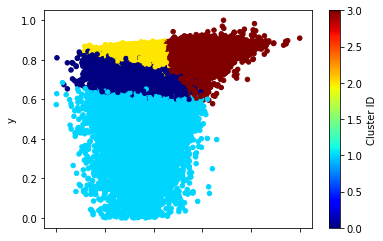

In [ ]:
########################## Fuzzy c means with 4 clusters
fcm=FCM(n_clusters=4)
fcm.fit(subset.to_numpy())
#fcm.centers
fcm.labels=fcm.predict(subset.to_numpy())
result=pd.concat((pd.DataFrame(subset.to_numpy()[:,:2], columns=['x', 'y']), pd.DataFrame(np.asarray(fcm.labels), columns=['Cluster ID'])), axis=1)
result.plot.scatter(x='x', y='y', c='Cluster ID', colormap='jet')

In [ ]:
temp=pd.DataFrame(np.asarray(fcm.u), columns=['Cluster 1 Prob', 'Cluster 2 Prob', 'Cluster 3 Prob', 'Cluster 4 Prob'])
export4=pd.concat((subset, temp), axis=1)
export4

,0,1,2,3,Cluster 1 Prob,Cluster 2 Prob,Cluster 3 Prob,Cluster 4 Prob
0,0.371055,0.613722,0.460930,0.549934,0.322927,0.513737,0.099701,0.063635
1,0.613812,0.843916,0.507860,0.599319,0.115922,0.046409,0.177471,0.660198
2,0.429319,0.693091,0.476690,0.554652,0.702782,0.073005,0.138902,0.085311
3,0.463555,0.846391,0.535086,0.616602,0.070165,0.014288,0.300047,0.615501
4,0.349795,0.848878,0.527060,0.629240,0.175363,0.031594,0.641638,0.151404
...,...,...,...,...,...,...,...,...
258724,0.402926,0.788991,0.431677,0.579851,0.402875,0.032541,0.441229,0.123356
258725,0.475298,0.785579,0.462893,0.561674,0.244614,0.035630,0.342141,0.377615
258726,0.539170,0.802474,0.481587,0.618997,0.060805,0.016980,0.104347,0.817868
258727,0.446020,0.649239,0.487269,0.558789,0.491396,0.210877,0.167237,0.130490


In [ ]:
#export4.to_csv("/content/gdrive/My Drive/Datasets/Clustered_4.csv")
export3.to_csv("/content/gdrive/My Drive/Datasets/Clustered_3.csv")

In [ ]:
starterFeatures

,rsi14,sma9_var,sma180_var,vwap_var
0,30.509761,-0.006223,-0.022679,-0.017526
1,46.452741,-0.001062,-0.004721,-0.007713
2,34.336224,-0.004443,-0.016648,-0.016589
3,36.584676,-0.001006,0.005697,-0.004279
4,29.113480,-0.000950,0.002626,-0.001767
...,...,...,...,...
258724,32.602899,-0.002293,-0.033872,-0.011582
258725,37.355860,-0.002370,-0.021928,-0.015194
258726,41.550637,-0.001991,-0.014774,-0.003803
258727,35.433061,-0.005427,-0.012600,-0.015767
